# Load metadata

This assumes that the file train.zip has been unzipped in the current directory.  If needed, insert code here to load the data from your computer.

In [0]:
import json
import numpy as np
from google.colab import drive

drive.mount('/content/drive/')
!unzip "/content/drive/My Drive/Colab Notebooks/train.zip"

# load metadata
with open("train.json", 'r') as f:
    metadata = json.load(f)
n_claims = len(metadata)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Archive:  /content/drive/My Drive/Colab Notebooks/train.zip
replace train.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# RNN architecture

We define a simple RNN that processes one token at time to update a hidden vector.  The last hidden vector is passed to a classifier that uses a softmax to predict the category.

In [0]:
import torch
import torch.nn as nn
import numpy as np
import random

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        return hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
      
      
class Classifier(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Classifier, self).__init__()
        self.hidden_size = hidden_size
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, hidden):
        hidden = self.h2o(hidden)
        output = self.softmax(hidden)
        return output

# Sample a claim
Sample a claim, tokenize it and embed it.

In [0]:
!pip install bpemb
from bpemb import BPEmb
n_embedding_dims = 50
bpemb_en = BPEmb(lang="en", dim=n_embedding_dims)

def sampleClaim(metadata): 
    id = random.randint(0, len(metadata) - 1)
#     id = random.randint(0, len(relevant_sentences) - 1)
    claim = metadata[id]["claim"]
    claimant = metadata[id]["claimant"]
    label = metadata[id]["label"]
    
#     print(relevant_sentences[id])
#     print(relevant_sentences[id][0]) # some do not have 5 sentences
#     print(relevant_sentences[id][1])
#     print(relevant_sentences[id][2])
#     print(relevant_sentences[id][3])
#     print(relevant_sentences[id][4])
    if (len(relevant_sentences[id]) != 5): return "SKIP", "SKIP", "SKIP", "SKIP", "SKIP", "SKIP", "SKIP", "SKIP", "SKIP", "SKIP"

    sentence_0 = relevant_sentences[id][0]
    sentence_1 = relevant_sentences[id][1]
    sentence_2 = relevant_sentences[id][2]
    sentence_3 = relevant_sentences[id][3]
    sentence_4 = relevant_sentences[id][4]
    
#     sentences = []
#     for sentence in relevant_sentences[id]:
#         sentences.append(sentence)
        
    embedding_claim = bpemb_en.embed(claim)
    embedding_claimant = bpemb_en.embed(claimant)
    embedded_sentence_0 = bpemb_en.embed(sentence_0)
    embedded_sentence_1 = bpemb_en.embed(sentence_1)
    embedded_sentence_2 = bpemb_en.embed(sentence_2)
    embedded_sentence_3 = bpemb_en.embed(sentence_3)
    embedded_sentence_4 = bpemb_en.embed(sentence_4)
    
#     embedded_sentences = [bpemb_en.embed(sentence) for sentence in sentences]
    
    embedding_claim = np.reshape(embedding_claim,(embedding_claim.shape[0],1,embedding_claim.shape[1]))
    embedding_claimant = np.reshape(embedding_claimant,(embedding_claimant.shape[0],1,embedding_claimant.shape[1]))
    embedded_sentence_0 = np.reshape(embedded_sentence_0,(embedded_sentence_0.shape[0],1,embedded_sentence_0.shape[1]))
    embedded_sentence_1 = np.reshape(embedded_sentence_1,(embedded_sentence_1.shape[0],1,embedded_sentence_1.shape[1]))
    embedded_sentence_2 = np.reshape(embedded_sentence_2,(embedded_sentence_2.shape[0],1,embedded_sentence_2.shape[1]))
    embedded_sentence_3 = np.reshape(embedded_sentence_3,(embedded_sentence_3.shape[0],1,embedded_sentence_3.shape[1]))
    embedded_sentence_4 = np.reshape(embedded_sentence_4,(embedded_sentence_4.shape[0],1,embedded_sentence_4.shape[1]))
#     for embedded_sentence in embedded_sentences:
#         embedded_sentence = np.reshape(embedded_sentence,(embedded_sentence.shape[0],1,embedded_sentence.shape[1]))
    
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    
    claim_tensor = torch.tensor(embedding_claim, dtype=torch.float)
    claimant_tensor = torch.tensor(embedding_claimant, dtype=torch.float)
    embedded_sentence_0 = torch.tensor(embedded_sentence_0, dtype=torch.float)
    embedded_sentence_1 = torch.tensor(embedded_sentence_1, dtype=torch.float)
    embedded_sentence_2 = torch.tensor(embedded_sentence_2, dtype=torch.float)
    embedded_sentence_3 = torch.tensor(embedded_sentence_3, dtype=torch.float)
    embedded_sentence_4 = torch.tensor(embedded_sentence_4, dtype=torch.float)
    
#     for embedded_sentence in embedded_sentences:
#         embedded_sentence = torch.tensor(embedded_sentence, dtype=torch.float)
       
    
#     embedded_sentences_tensor = []
#     embedded_sentences_tensor.append(claim_tensor)
#     embedded_sentences_tensor.append(claimant_tensor)
    
#     for embedded_sentence in embedded_sentences:
#         embedded_sentences_tensor.append(torch.tensor(embedded_sentence, dtype=torch.float) for embedded_sentence in embedded_sentences)
#     embedded_sentences_tensor = tuple(embedded_sentences_tensor)
    
    claim_claimant_tensor = torch.cat((claim_tensor, claimant_tensor), 0)
    
    claim_claimant_sentences_tensor = torch.cat((claim_tensor, claimant_tensor, embedded_sentence_0,
                                                embedded_sentence_1, embedded_sentence_2, embedded_sentence_3,
                                                embedded_sentence_4), 0)
    
    return claim_tensor, claim_claimant_tensor, claim_claimant_sentences_tensor, label_tensor, claim, claimant, sentence_0,\
            [], label, id



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Training procedure


In [0]:
def train(category_tensor, line_tensor, update=True):
    rnnOptimizer.zero_grad()
    classifierOptimizer.zero_grad()

    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        hidden = rnn(line_tensor[i], hidden)
    output = classifier(hidden)

    loss = criterion(output, category_tensor)
    if update:
        loss.backward()
        rnnOptimizer.step()
        classifierOptimizer.step()
        
    return output, loss.item()

# Preprocess articles

This code preprocesses the aticles to extract the top 5 sentences with greatest similarity to the claim according to tf-idf.

In [0]:
def preprocess_articles():

    from nltk.tokenize import sent_tokenize
    import nltk
    nltk.download('punkt')
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    # load metadata
    with open("train.json", 'r') as f:
        metadata = json.load(f)
    n_claims = len(metadata)

    # load related articles for each claim
    relevant_sentences = []
    for id in range(n_claims):
  
        if id % 500 == 0:
            print("Claims preprocessed: ",id)
        
        # retrieve related articles
        related_articles = metadata[id]['related_articles']
        articles = ""
        for article_id in related_articles:
            filename = "train_articles/" + str(article_id) + ".txt"
            # concatenate related articles
            with open(filename, 'r') as text_file:
                text = text_file.read()
                articles = articles + "\n" + text

        # split articles into sentences
        sentences = sent_tokenize(articles)

        # append claim to articles
        sentences.append(metadata[id]['claim'])

        # vectorize sentences based on tf-idf
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(sentences)
    
        # measure similarity between claim and each sentence
        similarity =  X[-1,:] @ np.transpose(X[:-2,:])
        similarity = similarity.todense()

        # find top 5 sentences with greatest similarity
        sorted_index = np.argsort(similarity)
        top_sentences = []
        for i in range(1,min(5,sorted_index.shape[1])+1):
            top_sentences.append(sentences[sorted_index[0,-i]])
        relevant_sentences.append(top_sentences)

   
    return metadata, relevant_sentences

metadata, relevant_sentences = preprocess_articles()
print("Metadata of claim 0:")
print(metadata[0]['claim'])
print("Metadata of claimant 0:")
print(metadata[0]['claimant'])
print("Relevant sentences of claim 0:")
print(relevant_sentences[0])
# print(relevant_sentences[0][0])
# print(relevant_sentences[0][1])
# print(relevant_sentences[0][2])
# print(relevant_sentences[0][3])
# print(relevant_sentences[0][4])


# Train RNN and plot results





Train: 1000  1% (0m 39s) average_accuracy=0.4401 average_loss=0.9760 "Chinese restaurant in Coral Springs, Fla., busted for selling dog meat to VIP customers." / 1 ✓
Test: 1000  1% (0m 39s) average_accuracy=0.4456 average_loss=0.9856 Earth "has not warmed for the last 17 years." / 1 ✓
Train: 2000  2% (1m 19s) average_accuracy=0.4476 average_loss=0.9738 "Forty-five states allow open carry of firearms." / 1 ✓
Test: 2000  2% (1m 19s) average_accuracy=0.4157 average_loss=0.9697  "Trump's audit of Obama has found a transfer of gold to Afghanistan."  / 1 ✓
Train: 3000  3% (1m 58s) average_accuracy=0.4678 average_loss=0.9579 Says Rick Scott’s per-pupil education spending is "about $200 less" than what it was under Charlie Crist during the recession. / 1 ✓
Test: 3000  3% (1m 58s) average_accuracy=0.4955 average_loss=0.9555 The government will "go out and buy my breast pump for my babies." / 1 ✓
Train: 4000  4% (2m 40s) average_accuracy=0.4905 average_loss=0.9756 A video shows a priest aggressi

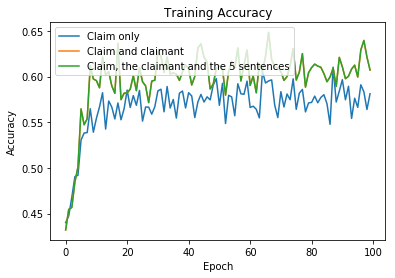

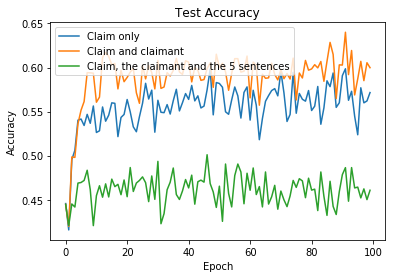

In [0]:
import time
import math

n_hidden = 128
n_categories = 3
rnn = RNN(n_embedding_dims, n_hidden)
classifier = Classifier(n_hidden, n_categories)

criterion = nn.NLLLoss()
learning_rate = 1e-4
rnnOptimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

n_iters = 100000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

train_data = metadata[:10000]
test_data = metadata[10000:]
train_cumulative_loss = 0
test_cumulative_loss = 0
train_cumulative_loss_claim_claimant = 0
test_cumulative_loss_claim_claimant = 0
train_cumulative_loss_claim_claimant_sentences = 0
test_cumulative_loss_claim_claimant_sentences = 0
average_train_accuracy = 0
average_train_accuracy_claim_claimant = 0
average_train_accuracy_claim_claimant_sentences = 0
average_test_accuracy = 0
average_test_accuracy_claim_claimant = 0
average_test_accuracy_claim_claimant_sentences = 0
all_train_losses = []
all_train_accuracies = []
all_train_losses_claim_claimant = []
all_train_accuracies_claim_claimant = []
all_train_losses_claim_claimant_sentences = []
all_train_accuracies_claim_claimant_sentences = []
all_test_losses = []
all_test_accuracies = []
all_test_losses_claim_claimant = []
all_test_accuracies_claim_claimant = []
all_test_losses_claim_claimant_sentences = []
all_test_accuracies_claim_claimant_sentences = []
count = 0

for iter in range(1, n_iters + 1):

#     return claim_tensor, claim_claimant_tensor, claim_claimant_sentences_tensor, label_tensor, claim, claimant, sentence_0
#             sentence_1, sentence_2, sentence_3, sentence_4, label, id
    
    train_claim_tensor, train_claim_claimant_tensor, train_claim_claimant_sentences_tensor,\
    label_tensor, claim_train, claimant, sentence_0,\
    sentences, label_train, id = sampleClaim(train_data)
    if (id == "SKIP"): continue
    
    # just claim
    train_output, train_loss = train(label_tensor, train_claim_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss += train_loss
    train_accuracy = 1 if train_guess_category == label_train else 0
    average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)
    
    # claim and claimant
    train_output_claim_claimant, train_loss_claim_claimant = train(label_tensor, train_claim_claimant_tensor)
    top_train_value_claim_claimant, top_train_index_claim_claimant = train_output_claim_claimant.topk(1)
    train_guess_category_claim_claimant = top_train_index_claim_claimant[0].item()
    train_cumulative_loss_claim_claimant += train_loss_claim_claimant
    train_accuracy_claim_claimant = 1 if train_guess_category_claim_claimant == label_train else 0
    average_train_accuracy_claim_claimant = (average_train_accuracy_claim_claimant * count + train_accuracy_claim_claimant) / (count+1)
    
    # claim and claimant and sentences
    train_output_claim_claimant_sentences, train_loss_claim_claimant_sentences = train(label_tensor, train_claim_claimant_sentences_tensor)
    top_train_value_claim_claimant_sentences, top_train_index_claim_claimant_sentences = train_output_claim_claimant_sentences.topk(1)
    train_guess_category_claim_claimant_sentences = top_train_index_claim_claimant_sentences[0].item()
    train_cumulative_loss_claim_claimant_sentences += train_loss_claim_claimant_sentences
    train_accuracy_claim_claimant_sentences = 1 if train_guess_category_claim_claimant_sentences == label_train else 0
    average_train_accuracy_claim_claimant_sentences = (average_train_accuracy_claim_claimant_sentences * count + train_accuracy_claim_claimant) / (count+1)
    
    # separate train and test line
    test_claim_tensor, test_claim_claimant_tensor, test_claim_claimant_sentences_tensor,\
    label_tensor, claim_test, claimant, sentence_0,\
    sentences, label_test, id = sampleClaim(test_data)
    if (id == "SKIP"): continue

    # just claim
    test_output, test_loss = train(label_tensor, test_claim_tensor, update=False)
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
    test_cumulative_loss += test_loss
    test_accuracy = 1 if test_guess_category == label_test else 0
    average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)

    # claim and claimant
    test_output_claim_claimant, test_loss_claim_claimant = train(label_tensor, test_claim_claimant_tensor, update=False)
    top_test_value_claim_claimant, top_test_index_claim_claimant = test_output_claim_claimant.topk(1)
    test_guess_category_claim_claimant = top_test_index_claim_claimant[0].item()
    test_cumulative_loss_claim_claimant += test_loss_claim_claimant
    test_accuracy_claim_claimant = 1 if test_guess_category_claim_claimant == label_test else 0
    average_test_accuracy_claim_claimant = (average_test_accuracy_claim_claimant * count + test_accuracy_claim_claimant) / (count+1)
    
    # claim and claimant and sentences
    test_output_claim_claimant_sentences, test_loss_claim_claimant_sentences = train(label_tensor, test_claim_claimant_sentences_tensor, update=False)
    top_test_value_claim_claimant_sentences, top_test_index_claim_claimant_sentences = test_output_claim_claimant_sentences.topk(1)
    test_guess_category_claim_claimant_sentences = top_test_index_claim_claimant_sentences[0].item()
    test_cumulative_loss_claim_claimant_sentences += test_loss_claim_claimant_sentences
    test_accuracy_claim_claimant_sentences = 1 if test_guess_category_claim_claimant_sentences == label_test else 0
    average_test_accuracy_claim_claimant_sentences = (average_test_accuracy_claim_claimant_sentences * count + test_accuracy_claim_claimant_sentences) / (count+1)
    count += 1
    
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == label else '✗ (%s)' % label
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, claim_train, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == label else '✗ (%s)' % label
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every, claim_test, test_guess_category, test_correct))
        all_train_losses.append(train_cumulative_loss / plot_every)
        all_train_accuracies.append(average_train_accuracy)
        all_test_losses.append(test_cumulative_loss / plot_every)
        all_test_accuracies.append(average_test_accuracy)
        
        all_train_losses_claim_claimant.append(train_cumulative_loss_claim_claimant / plot_every)
        all_train_accuracies_claim_claimant.append(average_train_accuracy_claim_claimant)
        all_test_losses_claim_claimant.append(test_cumulative_loss_claim_claimant / plot_every)
        all_test_accuracies_claim_claimant.append(average_test_accuracy_claim_claimant)
        
        all_train_losses_claim_claimant_sentences.append(train_cumulative_loss_claim_claimant_sentences / plot_every)
        all_train_accuracies_claim_claimant_sentences.append(average_train_accuracy_claim_claimant_sentences)
        all_test_losses_claim_claimant_sentences.append(test_cumulative_loss_claim_claimant_sentences / plot_every)
        all_test_accuracies_claim_claimant_sentences.append(average_test_accuracy_claim_claimant_sentences)
        
        train_cumulative_loss = 0
        average_train_accuracy = 0
        test_cumulative_loss = 0
        average_test_accuracy = 0
        
        train_cumulative_loss_claim_claimant = 0
        average_train_accuracy_claim_claimant = 0
        test_cumulative_loss_claim_claimant = 0
        average_test_accuracy_claim_claimant = 0
        
        train_cumulative_loss_claim_claimant_sentences = 0
        average_train_accuracy_claim_claimant_sentences = 0
        test_cumulative_loss_claim_claimant_sentences = 0
        average_test_accuracy_claim_claimant_sentences = 0
        count = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

f1 = plt.figure()
ax1 = f1.add_subplot(111)
ax1.set_title('Training Accuracy')
ax1.plot(all_train_accuracies)  # i, ii, iii accuracies 
ax1.plot(all_train_accuracies_claim_claimant) 
ax1.plot(all_train_accuracies_claim_claimant_sentences) 
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Claim only', 'Claim and claimant', 'Claim, the claimant and the 5 sentences'], loc='upper left')
f1.savefig("q2a_train.png")

f2 = plt.figure()
ax2 = f2.add_subplot(111)
ax2.set_title('Test Accuracy')
ax2.plot(all_test_accuracies) 
ax2.plot(all_test_accuracies_claim_claimant) 
ax2.plot(all_test_accuracies_claim_claimant_sentences) 
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Claim only', 'Claim and claimant', 'Claim, the claimant and the 5 sentences'], loc='upper left')
f2.savefig("q2a_test.png")